<span STYLE="font-size:150%"> 
    Segment microCT scans
</span>

Docker image: gnasello/slicer-env:2023-07-06 \
Latest update: 10 March 2023

- load image stack in Slicer
- segment mineralized tissue
- compute segmented statistics (volumes)

# Load libraries

In [1]:
# import pyslicer as ps
# import pyslicer as ps
import pyslicer as ps
import slicer
from pathlib import Path
import pandas as pd

# Volume input

## Load `.nrrd` file into 3D Slicer

Write the path of the `.nrrd` file and load it to Slicer

In [2]:
volume_file = 'microCT_volume/microCT_volume_preview.nrrd'

path = Path(volume_file)

# Remove image numbering _0000, _0001 ...
filename_output = path.stem[:-4]

In [3]:
masterVolumeNode = slicer.util.loadNodeFromFile(volume_file)

Print spacing

In [4]:
## mm
masterVolumeNode.GetSpacing()

(0.03485232, 0.03485232, 0.03485232)

Make ```segmented_volumes``` folder

In [5]:
output_directory = Path('segmented_volumes')

output_directory.mkdir(parents=True, exist_ok=True)

In [6]:
output_cylinderDefect_path = Path('segmented_volumes/polygonDefect')

output_cylinderDefect_path.mkdir(parents=True, exist_ok=True)

## Adjust window/level (brightness/contrast)

Adjust the image window/level from the GUI. It is enough to select a region where the signal is present ([youtube](https://slicer.readthedocs.io/en/latest/user_guide/user_interface.html#adjusting-image-window-level)). 

After, get the Window and Level properties from the displayNode associate to the VolumeNode and apply them programmatically anytime you run again the same image.

For more information on the relationship between window/level and brightness/contrast, see [Window and Level Contrast Enhancement](http://fisica.ciens.ucv.ve/curs/dipcourse/html/one-oper/window-level/front-page.html)

In [7]:
displayNode = masterVolumeNode.GetDisplayNode()
print('displayNode.SetWindow(' + str(displayNode.GetWindow()) + ')')
print('displayNode.SetLevel(' + str(displayNode.GetLevel()) + ')')

displayNode.SetWindow(12995.0)
displayNode.SetLevel(9567.5)


In [8]:
# displayNode = masterVolumeNode.GetDisplayNode()
# displayNode.AutoWindowLevelOff()
# displayNode.SetWindow(19678.0)
# displayNode.SetLevel(14679.0)

# Thresholding

## Create segmentation-related nodes

Create segmentation node

In [9]:
segmentationNode = ps.segmentation.segmentationNode(name='Segmentation')

Create temporary segment editor to get access to effects

In [10]:
segmentEditorWidget, segmentEditorNode = ps.segmentation.segmentEditorWidget(segmentationNode = segmentationNode, 
                                                                             masterVolumeNode = masterVolumeNode)

## Check different automatic segmentation algorithms

The first time you analyze an image/channel. Go to the ```Segment Editor```, add a new segment and choose the thresholding method. There you test different automatic thresholding technique and choose the one working best. For later analysis, you can just copy the thresholding values in the ```segments_greyvalues``` object at the beginning of this notebook.

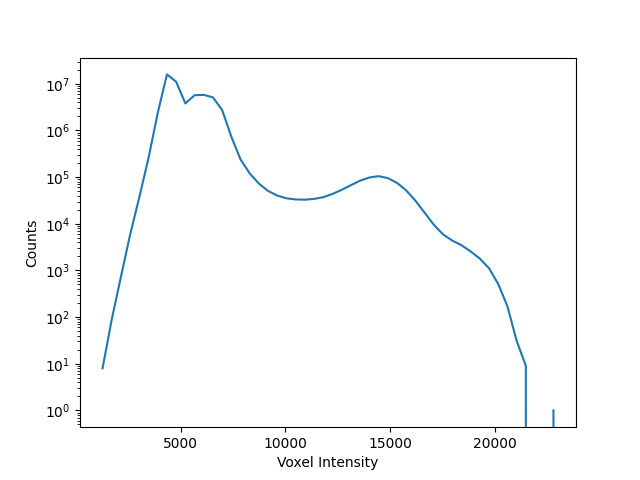

In [11]:
ps.volume.plot_histogram(masterVolumeNode, yscale='log')

Get automatic thresholding values, as indicated in [this script](https://github.com/jzeyl/3D-Slicer-Scripts/blob/db51967cc642837e8bae0fea1585a95074d8420b/load_dicom_modified_otsu.py#L56)

In [12]:
methods = [
            'HUANG',
            'INTERMODES',
            'ISO_DATA',
            'KITTLER_ILLINGWORTH',
            'LI',
            'MAXIMUM_ENTROPY',
            'MOMENTS',
            'OTSU',
            'RENYI_ENTROPY',
            'SHANBHAG',
            'TRIANGLE',
            'YEN'
            ]

thresholds = dict.fromkeys(methods, None)
thresholds

{'HUANG': None,
 'INTERMODES': None,
 'ISO_DATA': None,
 'KITTLER_ILLINGWORTH': None,
 'LI': None,
 'MAXIMUM_ENTROPY': None,
 'MOMENTS': None,
 'OTSU': None,
 'RENYI_ENTROPY': None,
 'SHANBHAG': None,
 'TRIANGLE': None,
 'YEN': None}

Otsu thresholding

OTSU threshold: 9065.787109375


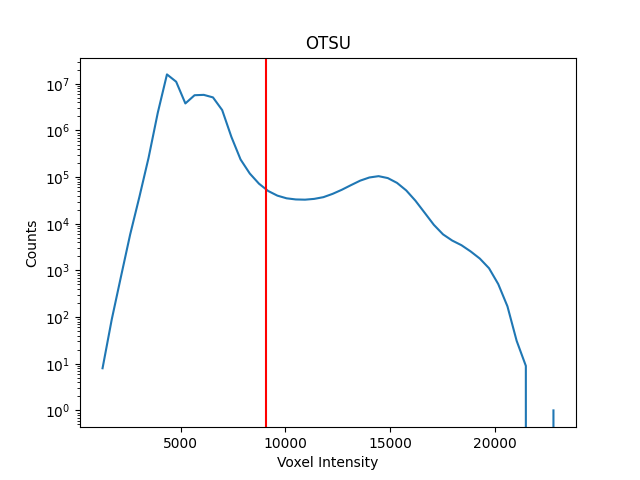

In [13]:
method = 'OTSU'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

IsoData thresholding

ISO_DATA threshold: 9581.02392578125


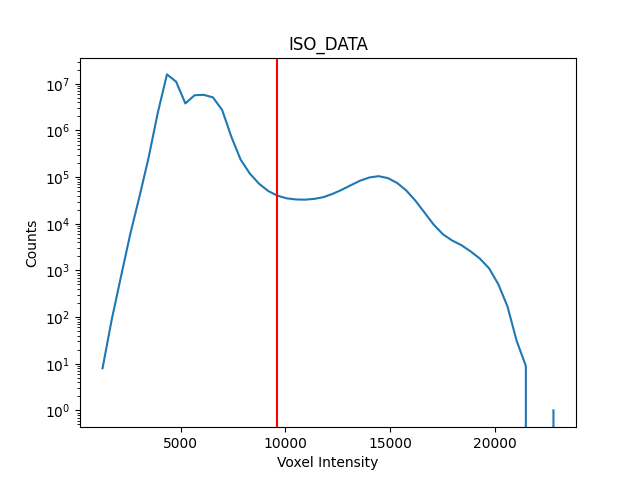

In [14]:
method = 'ISO_DATA'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

MOMENTS thresholding

MOMENTS threshold: 6833.09521484375


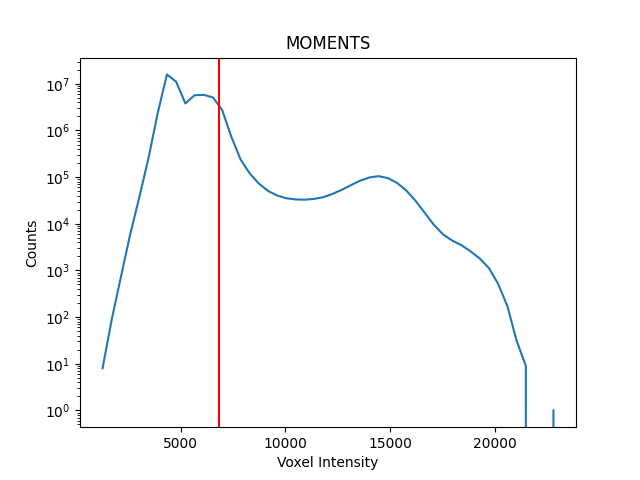

In [15]:
method = 'MOMENTS'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

MAXIMUM_ENTROPY thresholding

INTERMODES thresholding

## Select thresholding values

In [16]:
thresholds

{'HUANG': None,
 'INTERMODES': None,
 'ISO_DATA': 9581.02392578125,
 'KITTLER_ILLINGWORTH': None,
 'LI': None,
 'MAXIMUM_ENTROPY': None,
 'MOMENTS': 6833.09521484375,
 'OTSU': 9065.787109375,
 'RENYI_ENTROPY': None,
 'SHANBHAG': None,
 'TRIANGLE': None,
 'YEN': None}

In [17]:
segments_greyvalues = {
    "Bone": [thresholds['MOMENTS']*1.15, 65535], # [MaxEntropy, MaxIntensity]
    }

segments_greyvalues

{'Bone': [7858.059497070312, 65535]}

## Create segments by thresholding

In [18]:
# Avoid overwrite of overlapping segments
segmentEditorNode.SetOverwriteMode(slicer.vtkMRMLSegmentEditorNode.OverwriteNone)

ps.segmentation.segments_by_thresholding(segments_greyvalues, 
                                         segmentationNode,
                                         segmentEditorNode,
                                         segmentEditorWidget)

Set segments color

In [19]:
segments_color = {
    "Bone": (0.9450980392156862, 0.8392156862745098, 0.5686274509803921), # "Bone" color in Slicer
    }

segments_color

{'Bone': (0.9450980392156862, 0.8392156862745098, 0.5686274509803921)}

In [20]:
ps.segmentation.set_segments_color(segments_color, segmentationNode)

Get closed surface representation of the segment and visualize segment in 3D view, from [slicer scripting repository](https://slicer.readthedocs.io/en/latest/developer_guide/script_repository.html#export-nodes-warped-by-transform-sequence)

In [21]:
segmentationNode.CreateClosedSurfaceRepresentation()

True

# Isolate Skull

Duplicate `Bone` segmentation

In [22]:
copy_segmentName = 'Bone'

segmentation = segmentationNode.GetSegmentation()
copy_segmentID = segmentation.GetSegmentIdBySegmentName(copy_segmentName)

In [23]:
new_segmentName = 'Skull'

In [24]:
# '''
# COPY operation from the [SegmentEditorLogicalEffect](https://github.com/Slicer/Slicer/blob/4483cc0e6f288b0816b6329f1829d9ef8c5aa81a/Modules/Loadable/Segmentations/EditorEffects/Python/SegmentEditorLogicalEffect.py)
# '''
# 

# Create segment
addedSegmentID = segmentationNode.GetSegmentation().AddEmptySegment(new_segmentName)
segmentEditorNode.SetSelectedSegmentID(addedSegmentID)

# Fill by thresholding
segmentEditorWidget.setActiveEffectByName("Logical operators")
effect = segmentEditorWidget.activeEffect()
effect.setParameter('Operation','COPY')
effect.setParameter("ModifierSegmentID",copy_segmentID)
effect.self().onApply()

Keep only the largest segment (i.e. the skull)

In [25]:
ps.segmentation.keep_largest_island(minimum_size=1000, 
                                    segment_name='Skull', 
                                    segmentEditorNode=segmentEditorNode, 
                                    segmentEditorWidget=segmentEditorWidget)

In [26]:
displayNode = segmentationNode.GetDisplayNode()
displayNode.SetAllSegmentsVisibility(False) # Hide all segments
displayNode.SetSegmentVisibility('Skull', True) # Show specific segment

# Adjust skull segment manually 

Remove part of the skull segment manually using the `Scissor tool` in the `Segment Editor` module. 

Select the `Erase Inside` operation.

# Export Skull segmentation as `seg.nrrd` file (labelmap node)

Export a selection of segments (identified by their names), from [slicer tutorial](https://slicer.readthedocs.io/en/latest/developer_guide/script_repository.html#export-labelmap-node-from-segmentation-node)

In [27]:
seg_name = 'Skull'

In [28]:
skull_labelmap = ps.segmentation.individual_segment_to_labelmapNode(segmentName = seg_name,
                                                                      segmentationNode = segmentationNode,
                                                                      volumeNode = masterVolumeNode)

In [29]:
filename_output = seg_name + '.seg.nrrd'

slicer.util.exportNode(skull_labelmap, output_directory / filename_output)

True

# Define polygon defect 

## Draw points in Slicer UI

Before running the code below, go to the Slicer UI and define a **Point List** from the ```markups``` module. To select more points, click on `Toggle Markups Toolbar` and select the option `Place multiple control points`.

Set the name of the Point List node to ```F```. Any name is actually fine, but you should change the line below accoridngly.

**IMPORTANT** - Points in the Point List node ```F``` must be sorted to draw the polygon. You can move points in the list from the GUI (click `Advanced` in the Control Points List.

In [42]:
nodename = 'F'
pointsNode = slicer.util.getNode(nodename)

In [43]:
f_output = 'F.mrk.json'

slicer.util.exportNode(pointsNode, output_directory / f_output)

True

## Fit plane to PointList

In [44]:
planeNode, plane_dict = ps.markup.fitPlane_from_pointMarkup(pointNodename = 'F', namePlane = 'FittingPlane')
plane_dict

{'origin': array([-5.50355273, -4.43845026,  9.57207453]),
 'normal': array([ 0.74055926, -0.6690719 , -0.06256809]),
 'transform': array([[-0.19234503, -0.64387527,  0.74055926, -5.50355272],
        [-0.12183736, -0.73314287, -0.66907188, -4.4384503 ],
        [-0.97373459,  0.21892043, -0.06256832,  9.5720746 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [45]:
color = (68/255, 172/255, 100/255)
opacity = 0.4

modelDisplayNode = planeNode.GetDisplayNode()
modelDisplayNode.SetColor(color[0], color[1], color[2])
modelDisplayNode.SetOpacity(opacity)

## Create defect Polygon

In [46]:
projected_points = ps.markup.project_markupPoints_to_plane(pointNodename='F',
                                                           plane_normal=plane_dict['normal'],
                                                           plane_origin=plane_dict['origin']
                                                          )

Sort points clockwise

In [47]:
# projected_points = ps.model.sort_points_clockwise(projected_points)

Plot projected points to cylinder plane

Points projected to minimum cylinder axis


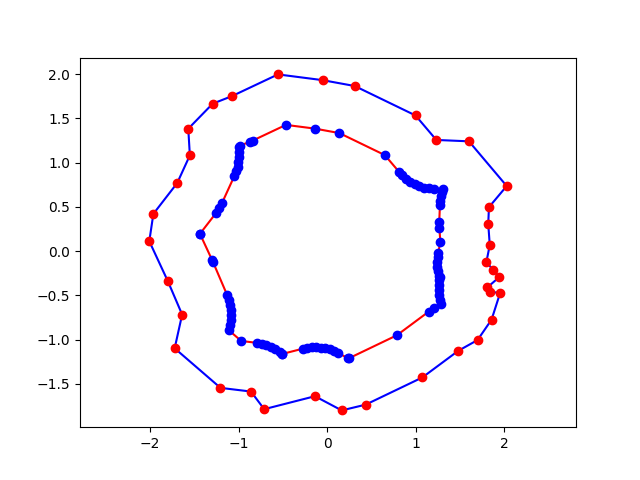

In [48]:
from shapely import geometry
import JupyterNotebooksLib as slicernb
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

polygon = geometry.Polygon(projected_points)
x, y = polygon.exterior.xy
plt.plot(x,y, 'b')
plt.plot(projected_points[:,0], projected_points[:,1], 'or')

polygon_shrunken = ps.model.shrink_or_swell_shapely_polygon(polygon, factor=0.2, swell=False)

if polygon_shrunken.type == 'MultiPolygon':
    from shapely import Polygon
    largest_polygon = Polygon()
    for p in polygon_shrunken.geoms:
        if largest_polygon.area < p.area:
            largest_polygon = p
    polygon_shrunken = largest_polygon

x, y = polygon_shrunken.exterior.xy
plt.plot(x,y, 'r')
plt.plot(x,y, 'ob')

# to net let the image be distorted along the axis
ax.axis('equal')

print('Points projected to minimum cylinder axis')
slicernb.MatplotlibDisplay(fig)

Compute defect area

In [49]:
defect_area = polygon.area
defect_area

11.388447127702316

Compute area reduction

In [50]:
area_reduction = (1 - polygon_shrunken.area / polygon.area) * 100

print('Area reduction in shrunk polygon \n')
print(area_reduction, '%')

Area reduction in shrunk polygon 

52.888887353941094 %


Create Defect polygon

In [56]:
height = 1 #mm
opacity = 0.4

color = (68/255, 172/255, 100/255)

rotate_x=180
rotate_y=0
rotate_z=-10

defectPolygonNode = ps.model.extrude_polygon_from_points(points=projected_points,
                                                         height=height, 
                                                         sort_points=False,
                                                         rotate_z=rotate_z,
                                                         rotate_y=rotate_y,
                                                         rotate_x=rotate_x,
                                                         transform=plane_dict['transform'],
                                                         nameModel='defectPolygon', 
                                                         color=color, 
                                                         opacity=opacity)

## Create inner defect polygon

Inner Defect polygon

In [57]:
height = 1 #mm
opacity = 0.4

x, y = polygon_shrunken.exterior.xy
import numpy as np
shrunk_points = np.array([x, y]).T

color = (230/255, 75/255, 53/255)

innerDefectPolygonNode = ps.model.extrude_polygon_from_points(points=shrunk_points,
                                                              height=height,
                                                              sort_points=False,
                                                              rotate_z=rotate_z,
                                                              rotate_y=rotate_y,
                                                              rotate_x=rotate_x,
                                                              transform=plane_dict['transform'],
                                                              nameModel='innerDefectPolygon', 
                                                              color=color, 
                                                              opacity=opacity)

## Export polygons and properties

In [58]:
directory_notebook = Path().parent.absolute()
sample_name = directory_notebook.stem
sample_name

'GN49_2024-04-21_4wk_Blank_9'

Defect cylinder diameter

In [59]:
# Scalar values
data = {'sample':sample_name,
        'defect_area_mm2':defect_area}

df_polygon = pd.DataFrame(data, index=[0])

df_polygon.to_csv(output_cylinderDefect_path / (sample_name + '_defect_area.csv'), index = False)

df_polygon

,sample,defect_area_mm2
0,GN49_2024-04-21_4wk_Blank_9,11.388447


Fitting plane model

In [60]:
model = planeNode

filename_output = model.GetName() + '.vtk'

slicer.util.exportNode(model, output_cylinderDefect_path / filename_output)

True

Defect cylinder model

In [61]:
model = defectPolygonNode

filename_output = model.GetName() + '.vtk'

slicer.util.exportNode(model, output_cylinderDefect_path / filename_output)

True

Inner cylinder model

In [62]:
model = innerDefectPolygonNode

filename_output = model.GetName() + '.vtk'

slicer.util.exportNode(model, output_cylinderDefect_path / filename_output)

True

# Grow skull segment

In [63]:
new_segmentName = 'Segment_mask'

In [64]:
copy_segmentName = 'Skull'

segmentation = segmentationNode.GetSegmentation()
copy_segmentID = segmentation.GetSegmentIdBySegmentName(copy_segmentName)

In [65]:
# '''
# COPY operation from the [SegmentEditorLogicalEffect](https://github.com/Slicer/Slicer/blob/4483cc0e6f288b0816b6329f1829d9ef8c5aa81a/Modules/Loadable/Segmentations/EditorEffects/Python/SegmentEditorLogicalEffect.py)
# '''

# Create segment
addedSegmentID = segmentationNode.GetSegmentation().AddEmptySegment(new_segmentName)
segmentEditorNode.SetSelectedSegmentID(addedSegmentID)

# Fill by thresholding
segmentEditorWidget.setActiveEffectByName("Logical operators")
effect = segmentEditorWidget.activeEffect()
effect.setParameter('Operation','COPY')
effect.setParameter("ModifierSegmentID",copy_segmentID)
effect.self().onApply()

In [66]:
# '''
# COPY operation from the [SegmentEditorMarginEffect](https://github.com/Slicer/Slicer/blob/4483cc0e6f288b0816b6329f1829d9ef8c5aa81a/Modules/Loadable/Segmentations/EditorEffects/Python/SegmentEditorMarginEffect.py)
# '''

# Fill by thresholding
segmentEditorWidget.setActiveEffectByName("Margin")
effect = segmentEditorWidget.activeEffect()
effect.setParameter('Operation','Grow')
effect.setParameter("MarginSizeMm",0.5)
effect.self().onApply()

# Merge defect model to segment mask

In [67]:
# Import the model into the segmentation node
slicer.modules.segmentations.logic().ImportModelToSegmentationNode(defectPolygonNode, segmentationNode)

True

In [68]:
segmentName = 'Segment_mask'

In [69]:
ModifierSegment_name = defectPolygonNode.GetName()

segmentation = segmentationNode.GetSegmentation()
ModifierSegmentID = segmentation.GetSegmentIdBySegmentName(ModifierSegment_name)

In [70]:
# '''
# LOGICAL_UNION operation from the [SegmentEditorLogicalEffect](https://github.com/Slicer/Slicer/blob/4483cc0e6f288b0816b6329f1829d9ef8c5aa81a/Modules/Loadable/Segmentations/EditorEffects/Python/SegmentEditorLogicalEffect.py)
# '''

# Create segment
selected_SegmentID = segmentation.GetSegmentIdBySegmentName(segmentName)
segmentEditorNode.SetSelectedSegmentID(selected_SegmentID)

# Fill by thresholding
segmentEditorWidget.setActiveEffectByName("Logical operators")
effect = segmentEditorWidget.activeEffect()
effect.setParameter('Operation','UNION')
effect.setParameter("ModifierSegmentID",ModifierSegmentID)
effect.self().onApply()

In [71]:
displayNode = segmentationNode.GetDisplayNode()
displayNode.SetAllSegmentsVisibility(False) # Hide all segments
displayNode.SetSegmentVisibility('Segment_mask', True) # Show specific segment

# Export segment mask as `seg.nrrd` file (labelmap node)

Export a selection of segments (identified by their names), from [slicer tutorial](https://slicer.readthedocs.io/en/latest/developer_guide/script_repository.html#export-labelmap-node-from-segmentation-node)

Bone LabelmapNode

In [72]:
seg_name = 'Segment_mask'

In [73]:
segMask_labelmap = ps.segmentation.individual_segment_to_labelmapNode(segmentName = seg_name,
                                                                      segmentationNode = segmentationNode,
                                                                      volumeNode = masterVolumeNode)

In [74]:
filename_output = seg_name + '.seg.nrrd'

slicer.util.exportNode(segMask_labelmap, output_directory / filename_output)

True

# Visualize segmentations in 3D view

Get viewNode

In [75]:
view = slicer.app.layoutManager().threeDWidget(0).threeDView()
viewNode = view.mrmlViewNode()

# Switch off cube and labels
viewNode.SetAxisLabelsVisible(False)
viewNode.SetBoxVisible(False)

color = (28/255, 29/255, 36/255)
# Set view background to RGB color of choice
viewNode.SetBackgroundColor(color[0], color[1], color[2])
viewNode.SetBackgroundColor2(color[0], color[1], color[2])

# Se?t Orthographic rendering, which is required to show the ruler in a 3D view
viewNode.SetRenderMode(viewNode.Orthographic)

# Set thick and white ruler
viewNode.SetRulerType(2) # 2 - thick
viewNode.SetRulerColor(0) # 0 - white

# Get camera position
cameraNode = slicer.modules.cameras.logic().GetViewActiveCameraNode(viewNode)

## Get camera position in 3D view

In [77]:
position = cameraNode.GetPosition()

viewAngle = cameraNode.GetViewAngle()

viewUp = cameraNode.GetViewUp()

focalPoint = cameraNode.GetFocalPoint()

parallelScale = cameraNode.GetParallelScale()

In [78]:
df1 = pd.DataFrame({'position':position,
                    'viewUp':viewUp,
                    'focalPoint':focalPoint})

df2 = pd.DataFrame({'viewAngle':[viewAngle],
                    'parallelScale':[parallelScale]})

df_camera = pd.concat([df1,df2], axis=1)
df_camera

,position,viewUp,focalPoint,viewAngle,parallelScale
0,-18.025611,0.111404,-4.811936,30.0,6.469837
1,-0.505234,-0.130156,-6.833157,NaN,NaN
2,10.667593,0.985215,8.337467,NaN,NaN


In [79]:
outputfile = output_directory / 'camera_view.csv'
df_camera.to_csv(outputfile, index=False, na_rep='NULL')